In [2]:
from periodicLatticeSolver import PeriodicLatticeSolver
from minimizer import Minimizer
import numpy as np
from FloorPlanClass import FloorPlan
from plotter import Plotter
PLS = PeriodicLatticeSolver(200, .02)
PLS.add_Injector()

L1 = PLS.Variable('L1', varMin=.01, varMax=.5)
L2= PLS.Variable('L2', varMin=.01, varMax=.5)
L3 =PLS.Variable('L3', varMin=.01, varMax=.5)
L4= PLS.Variable('L4', varMin=.01, varMax=.5)

Bp1 = PLS.Variable('Bp1', varMin=.1, varMax=.45)
Bp2 = PLS.Variable('Bp2', varMin=.1, varMax=.45)
Bp3 = PLS.Variable('Bp3', varMin=.1, varMax=.45)
Bp4 = PLS.Variable('Bp4', varMin=.1, varMax=.45)

rp1 =.03# PLS.Variable('rp1', varMin=.005, varMax=.03)
rp2 =.03# PLS.Variable('rp2', varMin=.005, varMax=.03)
rp3 =.03# PLS.Variable('rp3', varMin=.005, varMax=.03)
rp4 =.03# PLS.Variable('rp4', varMin=.005, varMax=.03)

#s = PLS.Variable('s', varMin=.005, varMax=.03)

r0=1
TL1=PLS.Variable('TL1',varMin=.5,varMax=1.5)
TL2=PLS.Variable('TL2',varMin=.5,varMax=1.5)


PLS.set_Track_Length(TL1=TL1,TL2=TL2)
PLS.begin_Lattice()

PLS.add_Bend(np.pi, r0, .45)
#PLS.add_Drift(L=test)
PLS.add_Lens(L4, Bp4, rp4)
PLS.add_Drift()
PLS.add_Combiner()
PLS.add_Drift()
PLS.add_Lens(L1, Bp1,rp1)
#PLS.add_Drift(L=.05)
PLS.add_Bend(np.pi, r0, .45)
#PLS.add_Drift(L=.05)
PLS.add_Lens(L2, Bp2, rp2)
PLS.add_Drift()
PLS.add_Lens(L3, Bp3, rp3)
#PLS.add_Drift(L=.05)
PLS.end_Lattice()

Lattice model completed


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


minCost for each thread:  [1.85912133 4.00000351 1.84049552 4.00000006 1.59111709 1.55141756
 1.77253892 1.72338359 1.58111116 1.81060119 1.52866609 1.51922212]


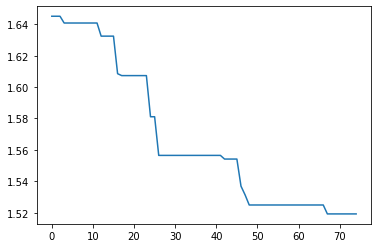

[ 0.40740141  0.16808569  0.48178198  0.39439482  0.11876759  0.26954858
  0.33292259  0.38731451  0.89987044  1.49411786  0.2         0.12477108
 -0.00166846] 1.5192221246067052
percent particles surviving (x,y): 17.0, 31.1
[ 0.40740141  0.16808569  0.48178198  0.39439482  0.11876759  0.26954858
  0.33292259  0.38731451  0.89987044  1.49411786  0.2         0.12477108
 -0.00166846] 1.5192221246067052
done
Total time 1 minutes and 47 seconds


In [3]:
minimizer=Minimizer(PLS)
minimizer.find_Global_Min(mut=.75, crossPop=.7, iterations=100, popPerDim=20,strategy='best/1')

[[0.01, 0.5],
 [0.01, 0.5],
 [0.01, 0.5],
 [0.01, 0.5],
 [0.1, 0.45],
 [0.1, 0.45],
 [0.1, 0.45],
 [0.1, 0.45],
 [0.5, 1.5],
 [0.5, 1.5],
 [0.05, 0.2],
 [0.025, 0.5],
 [-0.05, 0.05]]

In [20]:
q0=minimizer.sol.geneticSolX
def probe_Vicinity(q):
  limitList=[]
  
  for i in range(q.shape[0]):
    bounds=minimizer.sol.bounds[i]
probe_Vicinity(q0)